# EDA AND PREPROCESSING

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
from tqdm import tqdm
warnings.filterwarnings( 'ignore' )

import matplotlib.pyplot as plt
import os 
import sys
import time
import seaborn as sns
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Task1'
file_list = os.listdir(path)
print(file_list)

['train_1st_Bearing.csv', 'train_1st_high.csv', 'train_1st_Looseness.csv', 'train_1st_Normal.csv', 'train_1st_Unbalance.csv', 'train_2nd_Bearing.csv', 'train_2nd_Looseness.csv', 'train_2nd_Unbalance.csv', 'train_3rd_Normal.csv', 'train_3rd_Unbalance.csv']


In [4]:
def Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):

  #Normal[label 0] → Fault-free operating condition
  #Unbalance[label 1] → Unbalance between centers of mass and axis
  #Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
  #Belt-Looseness High[label 3] → High Looseness of V-belt
  #Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out

  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))-130
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in tqdm(range(Number_of_data)):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  return ds

def TEST_Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):
  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in tqdm(range(Number_of_data)):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  return ds

### DATA Loading

In [5]:
sub = pd.read_csv('/content/drive/MyDrive/sample_submission_classification.csv')
final = pd.read_csv('/content/drive/MyDrive/final.csv').iloc[:,1:]
test_Dataset = TEST_Dataset_Constructor(final)

100%|██████████| 12592/12592 [00:00<00:00, 15439.94it/s]


In [ ]:
test_Dataset

<TensorSliceDataset shapes: ((128, 2), ()), types: (tf.float64, tf.float64)>

In [ ]:
print(len(sub), len(final))

12592 1611776


In [6]:
train_1st_Bearing = pd.read_csv(os.path.join(path, file_list[0]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Looseness = pd.read_csv(os.path.join(path, file_list[1]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Normal = pd.read_csv(os.path.join(path, file_list[2]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Unbalance = pd.read_csv(os.path.join(path, file_list[3]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_high = pd.read_csv(os.path.join(path, file_list[4]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Bearing = pd.read_csv(os.path.join(path, file_list[5]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Looseness = pd.read_csv(os.path.join(path, file_list[6]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Unbalance = pd.read_csv(os.path.join(path, file_list[7]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Normal = pd.read_csv(os.path.join(path, file_list[8]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Unbalance = pd.read_csv(os.path.join(path, file_list[9]),float_precision = 'round_trip').iloc[:, 1:]

In [39]:
train_1st_Bearing

,1st_Bearing_c1,1st_Bearing_c2
0,-0.261178,1.530771
1,1.070614,-3.171052
2,-1.402249,-0.213261
3,0.609899,3.161540
4,-0.299414,-1.550640
...,...,...
18979195,-1.870846,-1.168753
18979196,0.737394,3.602421
18979197,1.284579,-2.678137
18979198,-2.875021,-2.860482


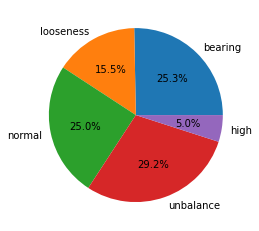

In [7]:
bearing = train_1st_Bearing.shape[0]+train_2nd_Bearing.shape[0]
looseness = train_1st_Looseness.shape[0]+train_2nd_Looseness.shape[0]
normal = train_1st_Normal.shape[0] + train_3rd_Normal.shape[0]
unbalance = train_1st_Unbalance.shape[0] + train_2nd_Unbalance.shape[0] + train_3rd_Unbalance.shape[0]
high = train_1st_high.shape[0] 

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

### Dataset Construction/Augmentation and Solving Class Imabalance Problem

In [9]:
Bearing1st_ds = Dataset_Constructor(train_1st_Bearing, label = 4 )
Looseness1st_ds = Dataset_Constructor(train_1st_Looseness,label = 2,window = 90)
Normal1st_ds = Dataset_Constructor(train_1st_Normal, label = 0 )
Unbalance1st_ds = Dataset_Constructor(train_1st_Unbalance, label = 1)
High1st_ds = Dataset_Constructor(train_1st_high, label = 3, window = 9)

100%|██████████| 1308731/1308731 [01:20<00:00, 16240.55it/s]


In [10]:
Bearing2nd_ds = Dataset_Constructor(train_2nd_Bearing, label = 4 )
Looseness2nd_ds = Dataset_Constructor(train_2nd_Looseness,label = 2,window = 90)
Unbalance2nd_ds = Dataset_Constructor(train_2nd_Unbalance, label = 1)
Normal3rd_ds = Dataset_Constructor(train_3rd_Normal, label = 0)
Unbalance3rd_ds = Dataset_Constructor(train_3rd_Unbalance, label = 1)

100%|██████████| 184373/184373 [00:11<00:00, 16457.52it/s]


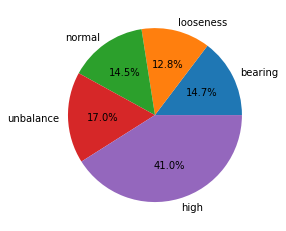

In [11]:
bearing = Bearing1st_ds.__len__().numpy() + Bearing2nd_ds.__len__().numpy()
looseness = Looseness1st_ds.__len__().numpy() + Looseness2nd_ds.__len__().numpy()
normal = Normal1st_ds.__len__().numpy() + Normal3rd_ds.__len__().numpy()
unbalance = Unbalance1st_ds.__len__().numpy() + Unbalance2nd_ds.__len__().numpy() + Unbalance3rd_ds.__len__().numpy()
high = High1st_ds.__len__().numpy()

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

In [12]:
batch_size = 128
Dataset = Bearing1st_ds.concatenate(Looseness1st_ds).concatenate(Normal1st_ds).concatenate(Unbalance1st_ds).concatenate(High1st_ds).concatenate(Bearing2nd_ds).concatenate(Looseness2nd_ds).concatenate(Unbalance2nd_ds).concatenate(Normal3rd_ds).concatenate(Unbalance3rd_ds).shuffle(buffer_size = 4518720, seed = 42).batch(batch_size).prefetch(1)

In [40]:
Dataset

<PrefetchDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.float64)>

In [14]:
Dataset.__len__().numpy()


24922

In [15]:
Valid_Dataset = Dataset.take(15 * batch_size) 
Train_Dataset = Dataset.skip(15 * batch_size)
Train_Dataset = Dataset.take(135 * batch_size)

AttributeError: ignored

# VISUALIZATION

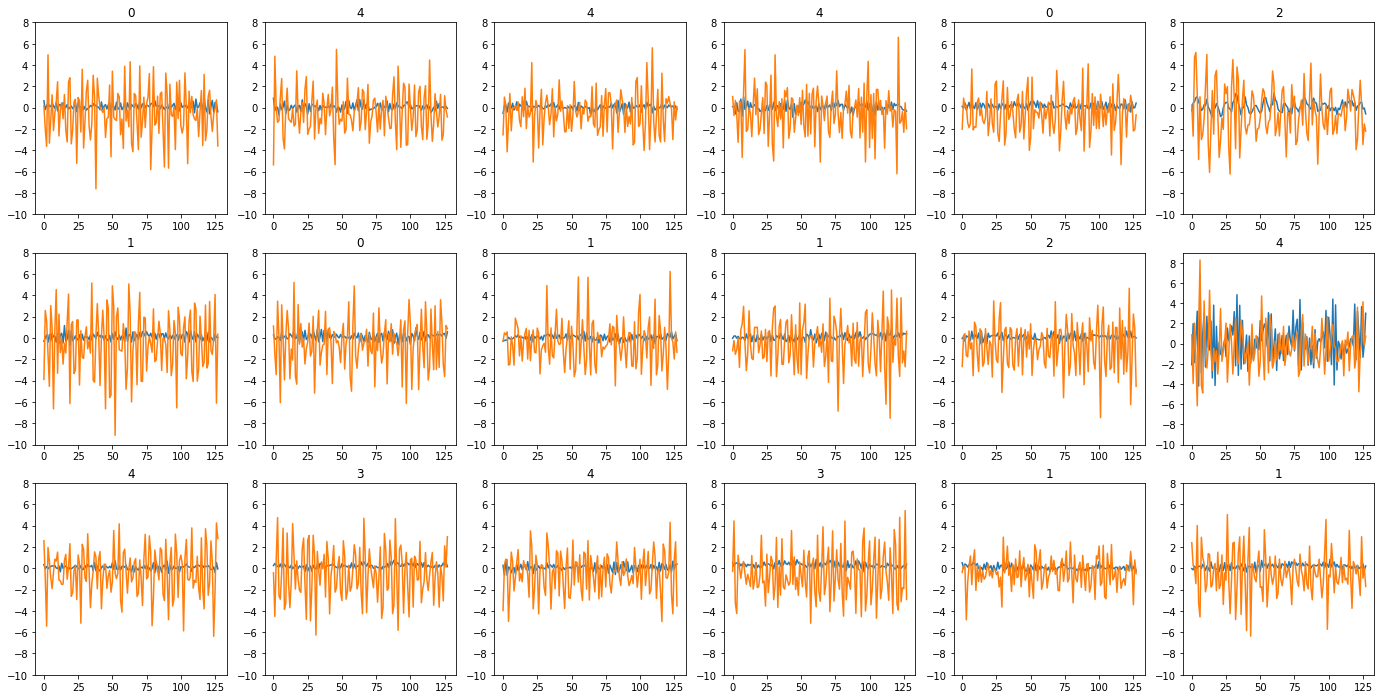

In [ ]:
rows = 3
cols = 6
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
for i, (audio, label) in enumerate(Dataset.unbatch().take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-10, 10, 2))
  label = int(label.numpy())#.decode('utf-8')
  ax.set_title(label)

#Fast Fourier Transform and Continuous Wavelet Transform

In [ ]:
Sample = list(Train_Dataset.unbatch().take(1).as_numpy_iterator())[0][0]

https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html

https://pywavelets.readthedocs.io/en/latest/ref/cwt.html

In [ ]:
import  pywt
from scipy import fftpack

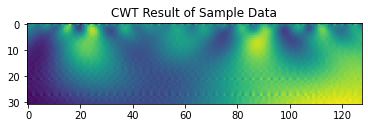

In [ ]:
coef, freqs = pywt.cwt(Sample ,np.arange(1,32), 'gaus1' , axis = 0)
plt.imshow(coef[:,:,0])
plt.title("CWT Result of Sample Data")
plt.show()

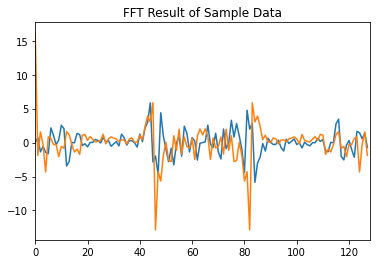

In [ ]:
imag = fftpack.fft(Sample[:,0]).imag
real = fftpack.fft(Sample[:,0]).real
plt.plot(imag)
plt.plot(real)
plt.xlim((0,128))
plt.title("FFT Result of Sample Data")
plt.show()

# Callback

In [ ]:
checkpoint_filepath = "./checkpoints"

callbacks = [
     keras.callbacks.EarlyStopping(
         
         monitor="val_loss",
         
         mode = "min",
         verbose=1
     ),
    keras.callbacks.TensorBoard(
        log_dir = './logs',
        update_freq = "epoch",
        histogram_freq=0,
        write_graph=True,
        write_images=False        
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        mode = 'min',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', 
        factor=0.2,
        patience=5, 
        min_lr=0.001
    )
]

#CUSTOM MODELING - first try



In [ ]:
CUSTOM_MODEL = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(128,2)),
        keras.layers.Conv1D(32, kernel_size=3, padding= 'same', activation = 'relu'),
        keras.layers.MaxPooling1D(2),
        keras.layers.Conv1D(16, kernel_size=3, padding = 'same', activation = 'relu'),
        keras.layers.MaxPooling1D(2),
        keras.layers.Flatten(),
        keras.layers.Dense(units = 20, activation = 'relu'),
        keras.layers.Dropout(0.4), # overfitting 방지
        keras.layers.Dense(units = 5, activation = 'softmax')  # 클래스 수 5개
])

CUSTOM_MODEL.summary()

CUSTOM_MODEL.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) # ANY CALLBACKS?

hist1 = CUSTOM_MODEL.fit(Train_Dataset, epochs = 2, shuffle = True, validation_data = Valid_Dataset)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 128, 32)           224       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 64, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 64, 16)            1552      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 32, 16)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                10260     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)               

# Custom modeling - CLSTM origin



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 128, 64)           448       
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 64)           256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 64, 64)            0         
_________________________________________________________________
activation_4 (Activation)    (None, 64, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 64, 64)            12352     
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64)            256       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 32, 64)           

INFO:tensorflow:Assets written to: ./checkpoints/assets


INFO:tensorflow:Assets written to: ./checkpoints/assets


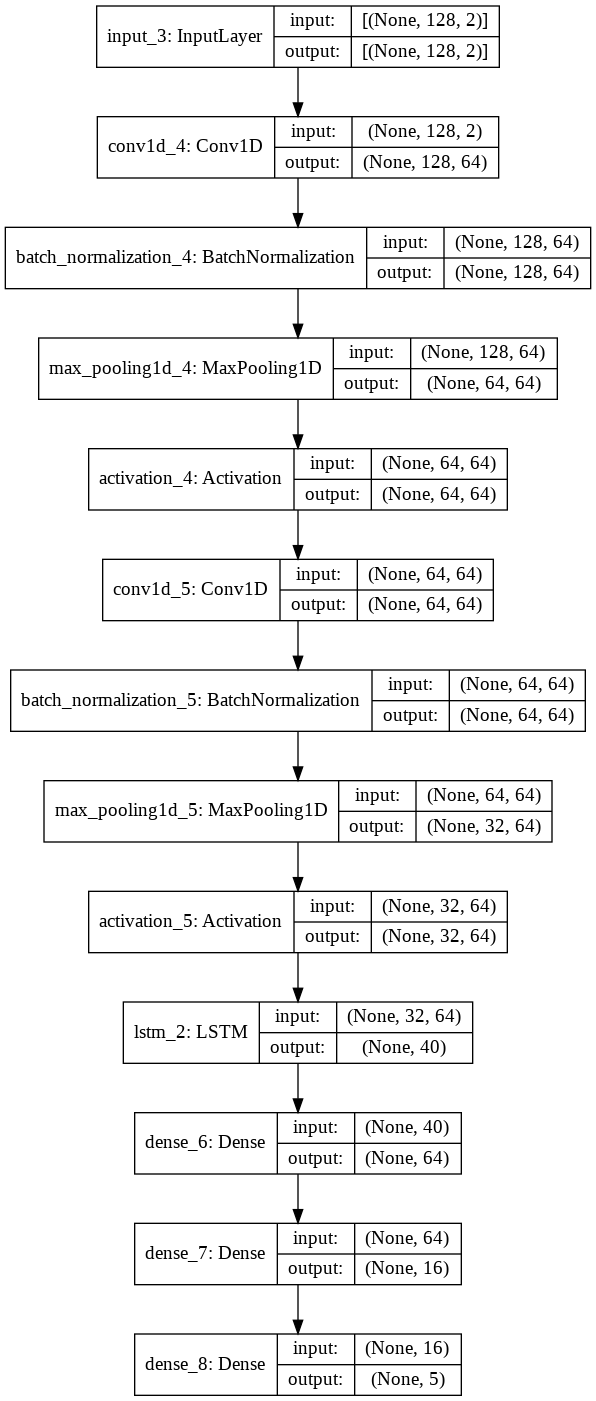

In [ ]:
model_clstm_begin = keras.models.Sequential([
        keras.layers.InputLayer(input_shape =(128,2)),
        keras.layers.Conv1D(64, kernel_size=3, padding= 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling1D(2),
        keras.layers.Activation('elu'),

        keras.layers.Conv1D(64, kernel_size=3, padding= 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling1D(2),
        keras.layers.Activation('elu'),

        keras.layers.LSTM(40, activation = 'tanh'),
        keras.layers.Dense(units = 64, activation = 'elu'),
        keras.layers.Dense(units = 16, activation = 'elu'),
        keras.layers.Dense(5, activation='softmax')
])

model_clstm_begin.summary()

model_clstm_begin.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
) # ANY CALLBACKS?

hist2 = model_clstm_begin.fit(Train_Dataset, epochs = 2, shuffle = True, validation_data = Valid_Dataset, callbacks = callbacks)
keras.utils.plot_model(model_clstm_begin, show_shapes=True)

# fft, cwt transform




In [55]:
from tensorflow.signal import fft

In [48]:
# scipy로 구현하려 함
# from_tensor_slice -> numpy-> array ->  fft -> ndarray -> tensor
# 근데 unbatch를 해야 되나 봄? tensor object가 attribute가 없다고 계속 오류가 남..

from scipy.fftpack import fft
# import tensorflow_datasets as tfds

class fft_real_revise(keras.layers.Layer):
    def __init__(self):
        super(fft_real_revise, self).__init__()
    def call(self, inputs):
        # inputs = tf.make_ndarray(inputs)
        # inputs = list(inputs.as_numpy_iterator())
        ffts =  fft(inputs).real
        return tf.convert_to_tensor(ffts)

class fft_imag_revise(keras.layers.Layer):
    def __init__(self):
        super(fft_imag_revise, self).__init__()
    def call(self, inputs):
        # inputs = tf.make_ndarray(inputs)
        ffts =  fft(inputs).imag
        return tf.convert_to_tensor(ffts, dtype = tf.complex64)

In [56]:
class fft_real(keras.layers.Layer):
    def __init__(self):
        super(fft_real, self).__init__()
    
    def call(self, inputs):
        ffts = fft(tf.cast(inputs, tf.complex64))
        return tf.math.real(ffts)

class fft_imag(keras.layers.Layer):
    def __init__(self):
        super(fft_imag, self).__init__()
    
    def call(self, inputs):
        ffts = fft(tf.cast(inputs, tf.complex64))
        return tf.math.imag(ffts)

In [50]:
# Reference - https://www.kaggle.com/mistag/wavelet1d-custom-keras-wavelet-transform-layer/notebook

%%writefile tf_cwt.py
# Based on Alexander Neergaard Olesen's CWT Python implementation. https://github.com/neergaard/CWT
# Adapted to Keras by Geir Drange
# MIT License
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math
import keras


# tf.experimental.numpy.kron does not work on windows, use numpy.kron directly through a tf.numpy_function() wrapper
@tf.function
def kron(a, b):
    return tf.numpy_function(np.kron, [a, b], tf.complex64)

# calculate CWT of input signal
class Wavelet1D(keras.layers.Layer):
    def __init__(self, nv=12, sr=1., flow=0., fhigh=0.5, batch_size=None, trainable=False):
        super(Wavelet1D, self).__init__()
        assert fhigh > flow, 'fhigh parameters must be > flow!'
        assert batch_size != None, 'batch size must be set!'
        
        self.batch_size = batch_size 
        self.nv = nv # number of voices
        self.sr = sr # sample rate (Hz)
        self.flow = flow # lowest frequency of interest (Hz)
        self.fhigh = fhigh # highest frequency of interest (Hz)
        self.trainable = trainable # True to train the wavelet filter bank

    def build(self, input_shape):
        assert len(input_shape) == 2, 'Input dimension must be 2! Dimension is {}'.format(len(input_shape))
        
        max_scale = input_shape[-1] // (np.sqrt(2) * 2)
        if max_scale <= 1:
            max_scale = input_shape[-1] // 2
        max_scale = np.floor(self.nv * np.log2(max_scale))
        scales = 2 * (2**(1/self.nv)) ** np.arange(0, max_scale + 1)
        frequencies = self.sr * (6 / (2 * np.pi)) / scales
        frequencies = frequencies[frequencies >= self.flow] # remove low frequencies
        scales = scales[0:len(frequencies)]
        frequencies = frequencies[frequencies <= self.fhigh] # remove high frequencies
        scales = scales[len(scales)-len(frequencies):len(scales)]
        # wavft
        padvalue = input_shape[-1] // 2
        n = padvalue*2+input_shape[-1]
        omega = np.arange(1, math.floor(n / 2) + 1, dtype=np.float64)
        omega = omega*(2 * np.pi) / n
        omega = np.concatenate((np.array([0]), omega, -omega[np.arange(math.floor((n - 1) / 2), 0, -1, dtype=int) - 1]))
        _wft = np.zeros([scales.size, omega.size])
        for jj, scale in enumerate(scales):
            expnt = -(scale * omega - 6) ** 2 / 2 * (omega > 0)
            _wft[jj, ] = 2 * np.exp(expnt) * (omega > 0)
        # parameters we want to use during call():
        self.wft = tf.Variable(_wft, trainable=self.trainable) # yes, the wavelets can be trainable if desired
        self.padvalue = padvalue
        self.num_scales = scales.shape[-1]
    
    # uses a loop - better to vectorize (TODO)
    def call(self, inputs):
        max_loop = tf.shape(inputs)[0]
        
        def sum_cwt(i, pre_data):
            next_data = tf.nn.embedding_lookup(inputs, i) 
            x = tf.concat([tf.reverse(next_data[0:self.padvalue], axis=[0]), next_data, tf.reverse(next_data[-self.padvalue:], axis=[0])], 0)
            f = tf.signal.fft(tf.cast(x, tf.complex64))
            cwtcfs = tf.signal.ifft(kron(tf.ones([self.num_scales, 1], dtype=tf.complex64), f) * tf.cast(self.wft, tf.complex64))
            logcwt = tf.math.log(tf.math.abs(cwtcfs[:, self.padvalue:self.padvalue + next_data.shape[-1]]))
            pre_data = tf.tensor_scatter_nd_add(pre_data, indices=[[i]], updates=[logcwt])
            i_next = i + 1
            return i_next, pre_data
                                 
        _, cwt = tf.while_loop(cond = lambda i, result: tf.less(i, max_loop),
                              body = sum_cwt,
                              loop_vars = (tf.constant(0, dtype=tf.int32), tf.zeros([self.batch_size, self.num_scales, inputs.shape[-1]], dtype = tf.float32)))
        return cwt

Writing tf_cwt.py


In [51]:
class Statiscal_Analysis(keras.layers.Layer):
    # mean, min, max, RMS
    # Var, Skewness, Kurtosis
    # Shape Factor, Crest Factor, Impulse Factor
    def __init__(self, length_of_signal = 128):
        super(Statiscal_Analysis, self).__init__()
        self.length_of_signal = length_of_signal
    def call(self, inputs):
        mean = tf.reduce_mean(inputs,axis = 1)
        max = tf.reduce_max(inputs,axis = 1)
        min = tf.reduce_min(inputs,axis = 1)
        RMS = tf.math.sqrt(tf.reduce_mean(tf.math.exp(inputs),axis = 1))
        var = tf.math.reduce_variance(inputs,axis = 1)
        #Skew = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),3),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),3)
        #Kurto = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),4),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),4) 
        #ShapeFactor = RMS*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
        #CrestFactor = tf.reduce_max(tf.abs(inputs),axis = 1)/RMS
        #ImpulseFactor = tf.reduce_max(tf.abs(inputs),axis = 1)*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
        # be aware of broadcasting
        return tf.stack([mean,max,min,RMS,var],axis = 1)

# 논문구현


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 128)          0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 128)          0           input_1[0][0]                    
__________________________________________________________________________________________________
wavelet1d (Wavelet1D)           (128, 4, 128)        1024        tf.__operators__.getitem[0][0]   
______________________________________________________________________________________________

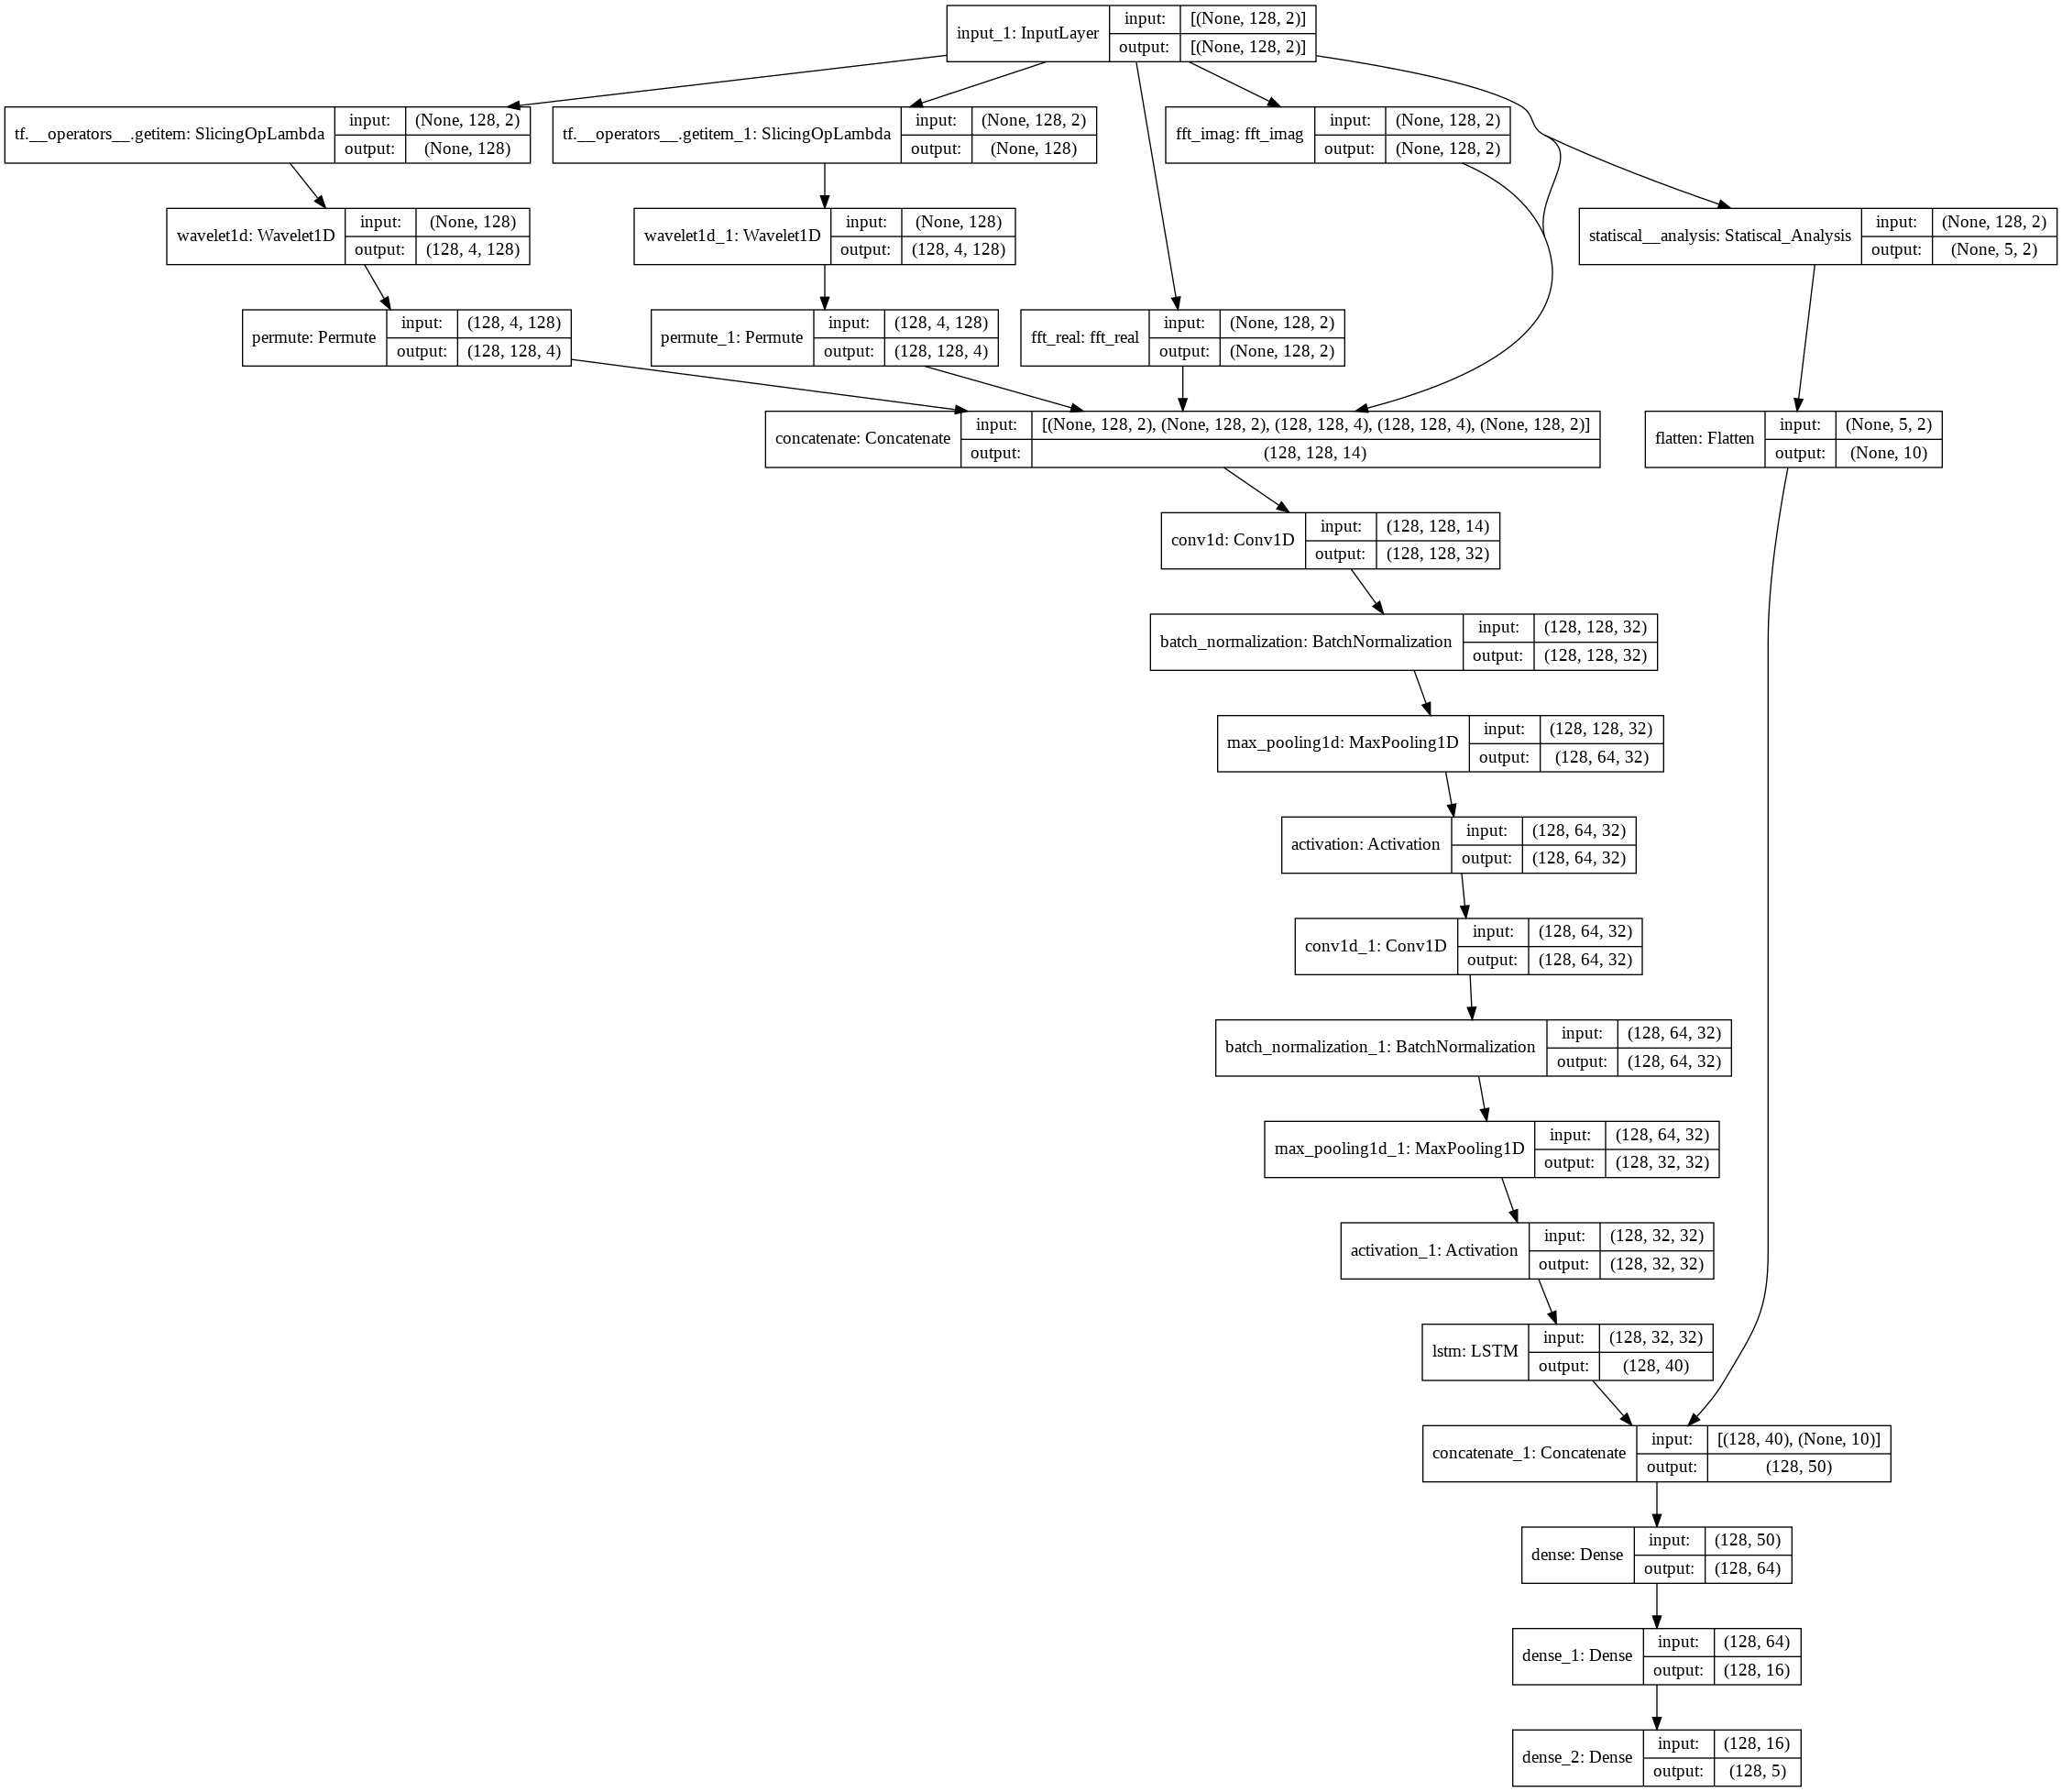

In [ ]:
from tf_cwt import Wavelet1D
def model_conv_lstm():

    model_input = keras.Input(shape = (128,2))
    x_fft_real = fft_real()(model_input)
    x_fft_imag = fft_imag()(model_input)

    Stat_analysis = Statiscal_Analysis()(model_input)
    Stat_analysis = keras.layers.Flatten()(Stat_analysis)

    c1 = Wavelet1D(batch_size = 128, nv = 12, sr = 1, flow = 0.4, fhigh = 12800)(model_input[:,:,0])
    c1 = keras.layers.Permute((2,1), input_shape=(128,4,128))(c1)
    c2 = Wavelet1D(batch_size = 128, nv = 12, sr = 1, flow = 0.4, fhigh = 12800)(model_input[:,:,1])
    c2 = keras.layers.Permute((2,1), input_shape=(128,4,128))(c2)
    Dyn_feature = keras.layers.Concatenate()([x_fft_real, x_fft_imag, c1, c2, model_input])

    x = keras.layers.Conv1D(32, kernel_size=3, padding= 'same')(Dyn_feature)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling1D(2)(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv1D(32, kernel_size=3, padding= 'same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling1D(2)(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.LSTM(40)(x)
    x = keras.layers.Concatenate()([x, Stat_analysis])

    x = keras.layers.Dense(units = 64, activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = keras.layers.Dense(units = 16, activation = 'relu', kernel_initializer = 'he_normal')(x)
    model_output = keras.layers.Dense(5, activation='softmax')(x)

    model = keras.Model(model_input, model_output)
    return model

Model_clstm = model_conv_lstm()

Model_clstm.summary()
Model_clstm.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
) # ANY CALLBACKS?

hist3 = Model_clstm.fit(Train_Dataset, epochs = 2, shuffle = True, validation_data = Valid_Dataset)
keras.utils.plot_model(Model_clstm, show_shapes=True)

#test

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
fft_real_2 (fft_real)           (None, 128, 2)       0           input_15[0][0]                   
__________________________________________________________________________________________________
fft_imag (fft_imag)             (None, 128, 2)       0           input_15[0][0]                   
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 6)       0           fft_real_2[0][0]                 
                                                                 fft_imag[0][0]               

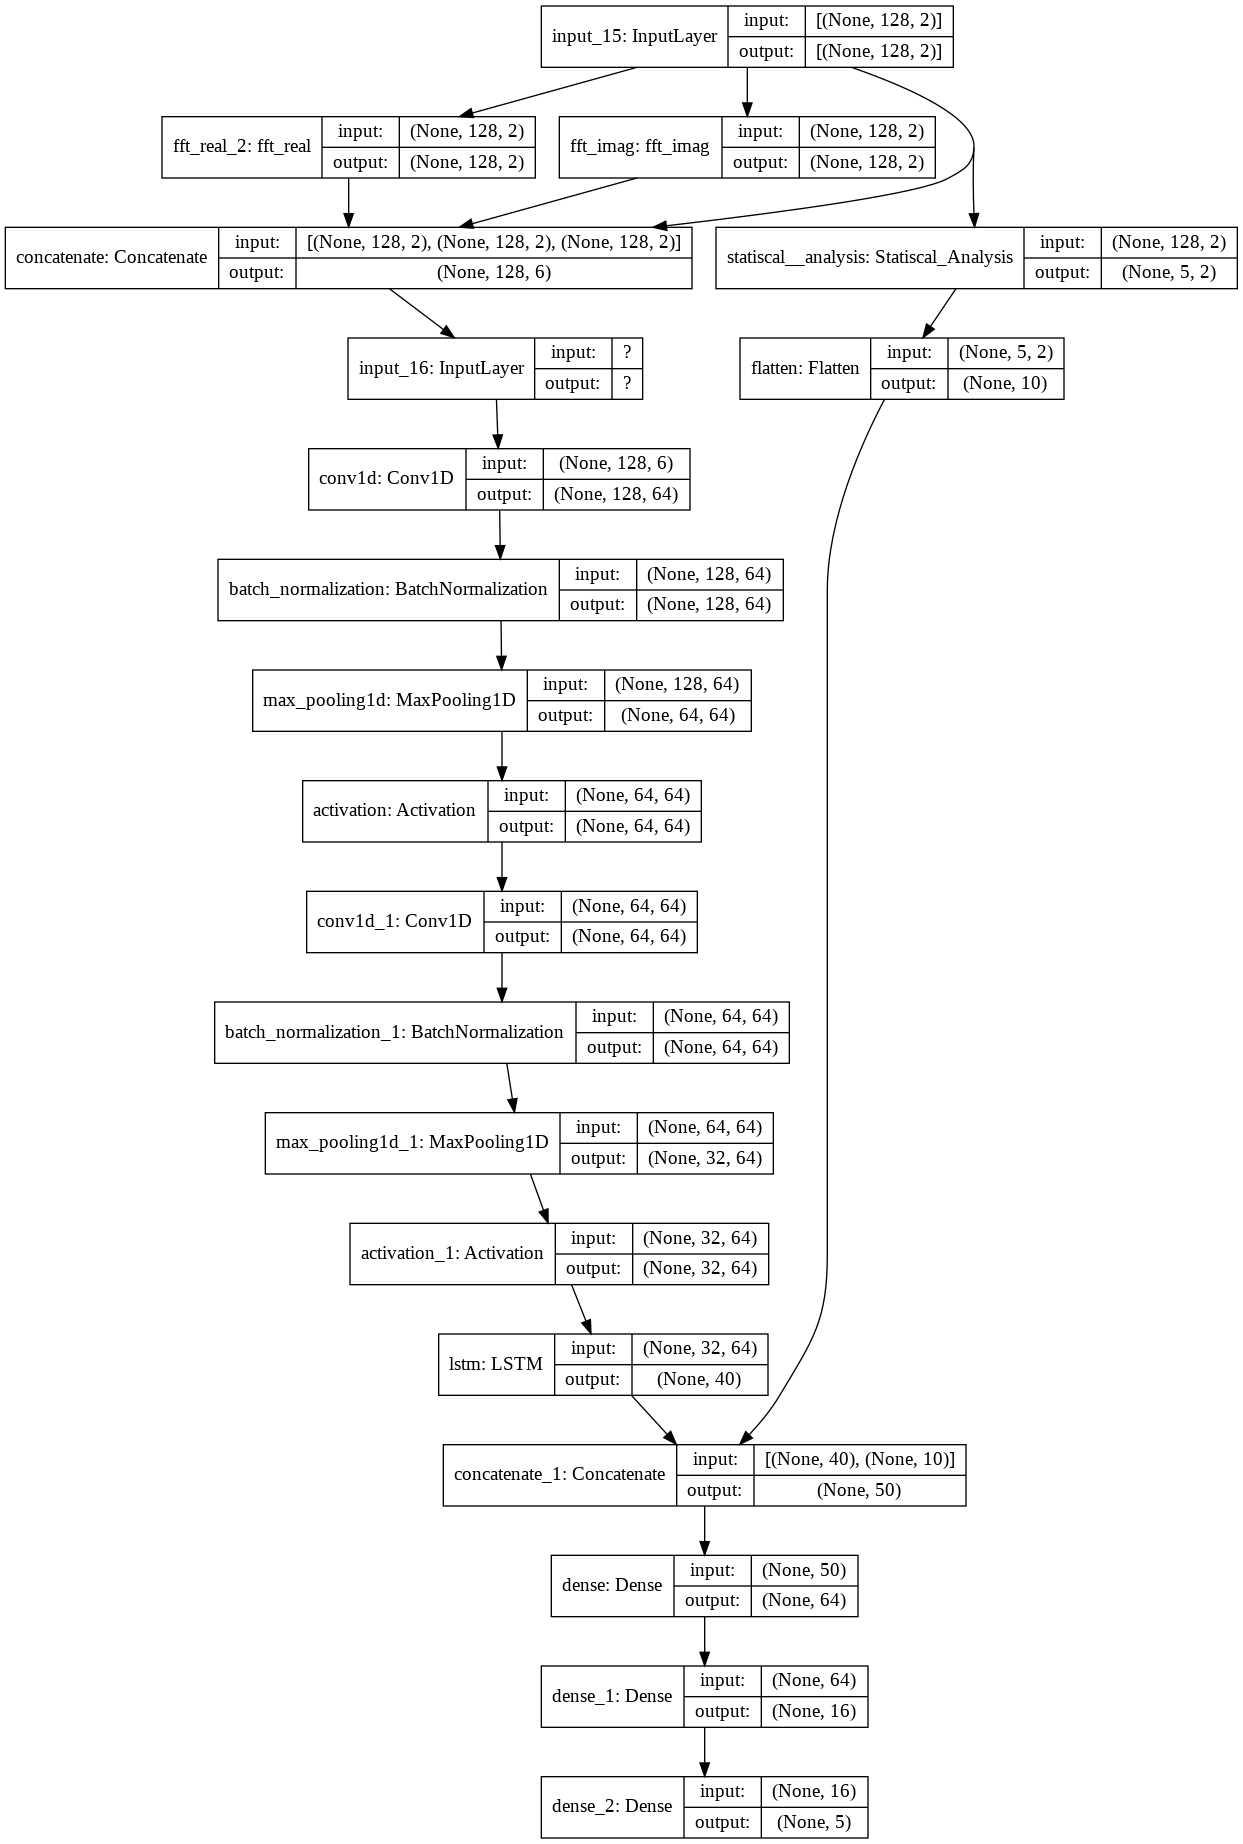

In [57]:
def model_conv_lstm():

    model_input = keras.Input(shape = (128,2))
    x_fft_real = fft_real()(model_input)
    x_fft_imag = fft_imag()(model_input)

    Stat_analysis = Statiscal_Analysis()(model_input)
    Stat_analysis = keras.layers.Flatten()(Stat_analysis)

    # c1 = Wavelet1D(batch_size = 128, nv = 12, sr = 1, flow = 0.4, fhigh = 12800)(model_input[:,:,0])
    # c1 = keras.layers.Permute((2,1), input_shape=(128,4,128))(c1)
    # c2 = Wavelet1D(batch_size = 128, nv = 12, sr = 1, flow = 0.4, fhigh = 12800)(model_input[:,:,1])
    # c2 = keras.layers.Permute((2,1), input_shape=(128,4,128))(c2)
    Dyn_feature = keras.layers.Concatenate()([x_fft_real, x_fft_imag, model_input])

    x = keras.layers.InputLayer(input_shape =(128,2))(Dyn_feature)
    x = keras.layers.Conv1D(64, kernel_size=3, padding= 'same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling1D(2)(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv1D(64, kernel_size=3, padding= 'same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling1D(2)(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.LSTM(40)(x)
    x = keras.layers.Concatenate()([x, Stat_analysis])

    x = keras.layers.Dense(units = 64, activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = keras.layers.Dense(units = 16, activation = 'relu', kernel_initializer = 'he_normal')(x)
    model_output = keras.layers.Dense(5, activation='softmax')(x)

    model = keras.Model(model_input, model_output)
    return model

Model_clstm = model_conv_lstm()

Model_clstm.summary()
Model_clstm.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
) # ANY CALLBACKS?

hist3 = Model_clstm.fit(Train_Dataset, epochs = 1, shuffle = True, validation_data = Valid_Dataset)
keras.utils.plot_model(Model_clstm, show_shapes=True)

In [ ]:
test_Dataset = test_Dataset.batch(batch_size)
test_Dataset

<BatchDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.float64)>

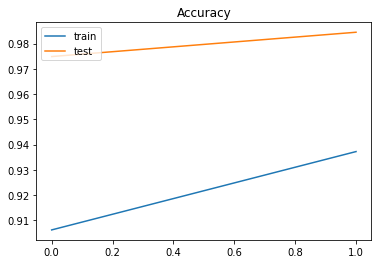

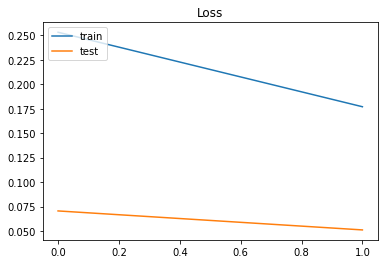

In [ ]:
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('Loss')
plt.legend(['train','test'], loc='upper left')
plt.show()

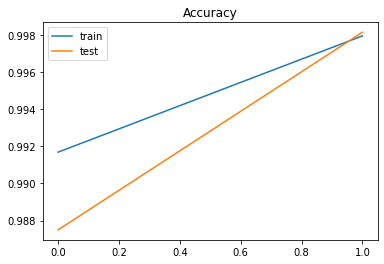

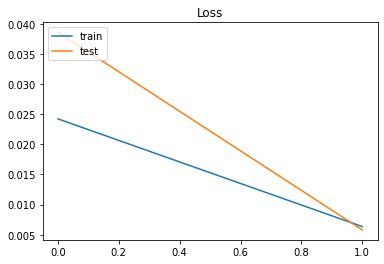

In [ ]:
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Loss')
plt.legend(['train','test'], loc='upper left')
plt.show()

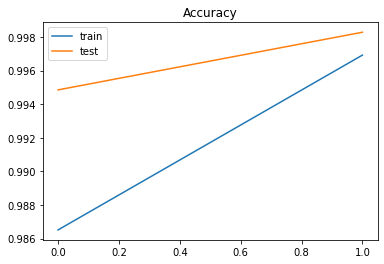

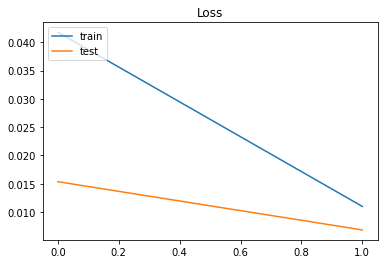

In [ ]:
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('Loss')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [58]:
pred = Model_clstm.predict(test_Dataset)
a = np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/CUSTOM_MODEL_Revised.csv', index = False)
sub.hist()

ValueError: ignored

In [59]:
Train_Dataset

<TakeDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.float64)>

In [60]:
Train_Dataset

<TakeDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.float64)>